In [5]:
pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=73f223b04712717fdb77b789114467739530640628948ee2b479b14e197dffbf
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, losses, metrics, callbacks, datasets
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from joblib import dump, load
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
seed=42
tf.random.set_seed(seed)

# Importing data:
Here we are importing the data.The data is normalized.We also check the shape of the train data and test data.Lastly we flatten the test and the training data.

In [2]:
(X_train,y_train),(X_test,y_test)=datasets.fashion_mnist.load_data()
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt',
            'Sneaker','Bag','Ankle Boot']
# Normalizing
X_train, X_test= X_train/255.0, X_test/255.0

# Checking shape of the data
print(f"X-train shape: {X_train.shape}")
print(f"y-train shape: {y_train.shape}")
print(f"X-test shape: {X_test.shape}")
print(f"y-test shape: {y_test.shape}")

# Flattening data for Logistic Regression
X_train_flatten= X_train.reshape(X_train.shape[0],-1)
y_train_flatten= y_train.reshape(y_train.shape[0],-1)
X_test_flatten= X_test.reshape(X_test.shape[0],-1)
y_test_flatten= y_test.reshape(y_test.shape[0],-1)

4431872/4422102 [==============================] - 0s 0us/step
X-train shape: (60000, 28, 28)
y-train shape: (60000,)
X-test shape: (10000, 28, 28)
y-test shape: (10000,)


Here we check on an item.

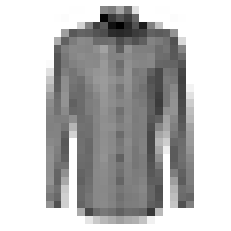

It is a  Shirt


In [3]:
index=3000
plt.imshow(X_train[index],cmap='binary')
plt.axis('off')
plt.show()

print('It is a ',class_names[y_train[index]])

Here first we train a logistic regression
model on a sample of  labeled instances from the  dataset such that the sample size is like 10,30,..90.We observe that the score of the fit is very low for all of the cases.We try to increase them by using clustering.We cluster the training set into  clusters of size k.This increases the accuracy.

In [6]:
from memory_profiler import profile
%load_ext memory_profiler

In [8]:
import time
%memit
t1 = time.perf_counter()
k_cluster = [i for i in range(10,110,20)]
diff=[]#vector containing the increment in accuracy after doing clustering
for k in k_cluster:
  #logistic regression on sample of size k
  log_reg_n = LogisticRegression(multi_class="ovr", solver="saga", random_state=seed)
  log_reg_n.fit(X_train_flatten[:k], y_train_flatten.ravel()[:k])
  #k means clustering on the data
  kmeans1 = KMeans(init='k-means++',n_clusters=k, random_state=seed)
  X_items_dist = kmeans1.fit_transform(X_train_flatten)
  representative_items_idx = np.argmin(X_items_dist, axis=0)
  X_representative_items = X_train_flatten[representative_items_idx]
  y_representative_items = np.squeeze(y_train_flatten[representative_items_idx]).astype('int32')
  log_reg = LogisticRegression(multi_class="ovr", solver="saga", random_state=seed)
  log_reg.fit(X_representative_items, y_representative_items)
  t1 = log_reg_n.score(X_test_flatten, y_test_flatten.ravel())
  t2 = log_reg.score(X_test_flatten,y_test_flatten)

  diff.append((t2-t1))
  print("k:",k)
  print(" accuracy of logistic regression ",t1)
  print(" accuracy of logistic regression after clustering",t2)
tw = time.perf_counter() - t1
print(tw, "seconds")



peak memory: 1057.15 MiB, increment: 0.05 MiB
k: 10
 accuracy of logistic regression  0.3736
 accuracy of logistic regression after clustering 0.483
k: 30
 accuracy of logistic regression  0.5716
 accuracy of logistic regression after clustering 0.635
k: 50
 accuracy of logistic regression  0.6618
 accuracy of logistic regression after clustering 0.6631
k: 70
 accuracy of logistic regression  0.691
 accuracy of logistic regression after clustering 0.659
k: 90
 accuracy of logistic regression  0.6825
 accuracy of logistic regression after clustering 0.6928
995.238330875 seconds


In [ ]:
diff.index(max(diff))

0

Here we observe that the increment is maximum when k=10.So we further try  propagate the labels to all the other instances in the same cluster.We then try to increase the accuracy even by propagating the labels to the 25% of the instances that are closest to the centroids.

In [ ]:
k=10
%memit
import time
t1 = time.perf_counter()
y_train_propagated = np.empty(len(X_train_flatten), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans1.labels_==i] = y_representative_items[i]
log_reg4 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=1000, random_state=seed)
log_reg4.fit(X_train_flatten, y_train_propagated)

percentile_closest = 25

X_cluster_dist = X_items_dist[np.arange(len(X_train_flatten)), kmeans1.labels_]
for i in range(k):
    in_cluster = (kmeans1.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train_flatten[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg5 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=1000, random_state=seed)
log_reg5.fit(X_train_partially_propagated, y_train_partially_propagated)
  
  

print("k:",k)
print(" accuracy of logistic regression after label propagation",log_reg4.score(X_test_flatten,y_test_flatten))
print(" accuracy of logistic regression after 25% closest instances are labelled ",log_reg5.score(X_test_flatten,y_test_flatten))
tw = time.perf_counter() - t1
print(tw, "seconds")
from memory_profiler import profile
%load_ext memory_profiler
%memit dav = LogisticRegression(multi_class="ovr", solver="saga", max_iter=1000, random_state=seed).fit(X_train_partially_propagated, y_train_partially_propagated)


peak memory: 1845.43 MiB, increment: -0.01 MiB


In [ ]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

We try to now experiment with k=100

In [ ]:
k=100
import time
t1 = time.perf_counter()
%%memit
log_reg_n = LogisticRegression(multi_class="ovr", solver="saga", random_state=seed)
log_reg_n.fit(X_train_flatten[:k], y_train_flatten.ravel()[:k])

kmeans1 = KMeans(init='k-means++',n_clusters=k, random_state=seed)
X_items_dist = kmeans1.fit_transform(X_train_flatten)
representative_items_idx = np.argmin(X_items_dist, axis=0)
X_representative_items = X_train_flatten[representative_items_idx]
y_representative_items = np.squeeze(y_train_flatten[representative_items_idx]).astype('int32')
log_reg = LogisticRegression(multi_class="ovr", solver="saga", random_state=seed)
log_reg.fit(X_representative_items, y_representative_items)
  
  
y_train_propagated = np.empty(len(X_train_flatten), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans1.labels_==i] = y_representative_items[i]
log_reg4 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=1000, random_state=seed)
log_reg4.fit(X_train_flatten, y_train_propagated)

percentile_closest = 25

X_cluster_dist = X_items_dist[np.arange(len(X_train_flatten)), kmeans1.labels_]
for i in range(k):
    in_cluster = (kmeans1.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train_flatten[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg5 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=1000, random_state=seed)
log_reg5.fit(X_train_partially_propagated, y_train_partially_propagated)
  
  

print("k:",k)
print(" accuracy of logistic regression ",log_reg_n.score(X_test_flatten, y_test_flatten.ravel()))
print(" accuracy of logistic regression after clustering",log_reg.score(X_test_flatten,y_test_flatten))
print(" accuracy of logistic regression after label propagation",log_reg4.score(X_test_flatten,y_test_flatten))
print(" accuracy of logistic regression after 25% closest instances are labelled ",log_reg5.score(X_test_flatten,y_test_flatten))

tw = time.perf_counter() - t1
print(tw, "seconds")


In [ ]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

In [ ]:
%memit dav = LogisticRegression(multi_class="ovr", solver="saga", max_iter=1000, random_state=seed).fit(X_train_partially_propagated, y_train_partially_propagated)
